# Package Imports

In [22]:
# Standard packages
import time
import numpy as np
from scipy.sparse import csr_matrix, vstack
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt


# Spotify model packages
import spotify_data as data
import spotify_tools as tools
import spotify_models as models
import spotify_metrics as metrics

#allows for autoreload if import files change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random Choice Model

### Data Loading

Load data and control its size since the volume of data is enormous for some machines

In [2]:
P = data.get_playlist_track_matrix()

#reduce the amount of data for slower machines
P,_ = train_test_split(P,train_size= .1)

### Random Baseline Model

As a baseline for evaluation, we introduce a simple **random model** that recommends songs uniformly at random.

#### Model Description

The `Spotify_Random` model does not learn from the training data. Instead, it simply selects a fixed number of songs uniformly at random from the entire catalog, without replacement. This serves as a control to help us interpret the quality of more sophisticated models.

The random model is evaluated on the same test playlists as other models. Specifically, it predicts 25 songs for each playlist, and its predictions are compared to the held-out songs using several metrics:

- **Accuracy score**: Measures the fraction of predicted songs that exactly match the hidden (ground-truth) continuation.
- **Artist vibe score**: Measures the cosine similarity between predicted and hidden songs after projecting both into artist space.
- **Album vibe score**: Same as above but in album space.
- **Co-occurrence vibe score**: Uses a song co-occurrence matrix derived from the training data to assess how well the prediction "feels" like the true continuation.

These metrics help establish a lower bound on performance — any reasonable model should significantly outperform this random baseline.


In [3]:
A = data.get_artist_track_matrix()
B = data.get_album_track_matrix()

train_playlists,test_playlists = train_test_split(P,train_size= 0.2)

rnd_model = models.Spotify_Random()
rnd_model.fit(train_playlists.shape[1])


test_partial, test_hidden = tools.csr_col_split(test_playlists, 10,'shuffle')

predictions = rnd_model.predict(test_partial.shape[0], 25)


# Compute scores
acc = metrics.prediction_accuracy_score(test_hidden, predictions).mean()
artist_vibe = metrics.transform_cosine_score(test_hidden, predictions, A).mean()
album_vibe = metrics.transform_cosine_score(test_hidden, predictions, B).mean()


cooccur_matrix = train_playlists.T @ train_playlists

vibe_score = metrics.transform_cosine_score(test_hidden, predictions, cooccur_matrix).mean()


# Summary
print(f"Accuracy score:          {acc:.3f}")
print(f"Artist vibe score:       {artist_vibe:.3f}")
print(f"Album vibe score:        {album_vibe:.3f}")
print(f"Co-occurrence vibe score:{vibe_score:.3f}")

Accuracy score:          0.000
Artist vibe score:       0.001
Album vibe score:        0.000
Co-occurrence vibe score:0.056


# KNN Model

### Data Loading

Load data and control its size since the volume of data is enormous for some machines.  
We use only a small fraction of the playlist-track matrix for this experiment:

In [4]:
P = data.get_playlist_track_matrix()
P,_ = train_test_split(P,train_size= 0.05)

#define which exponents (alpha) you want to test
alpha = np.linspace(0.1, 2.5, 25)
fcts = [lambda x, a=a: 1/(x**a + 0.5) for a in alpha]


### Experiment: Evaluating KNN-Based Recommendations with Varying Distance Functions

In this experiment, we evaluate a KNN-style recommendation model that predicts songs based on their proximity to a given playlist in a song co-occurrence graph. The key idea is to define a **distance function** over co-occurrence counts, parameterized by an exponent $\alpha$:

$$
f(x) = \frac{1}{x^\alpha + 0.5}
$$

This function is used to transform raw co-occurrence counts into distance-like values, where higher co-occurrence implies greater similarity. For each value of $\alpha$, a different version of the model is trained and evaluated.

#### Experimental Setup

- The playlist-song matrix $P$ is split using K-fold cross-validation, with one fold per $\alpha$ value.
- For each fold:
  - The model is trained on the training split using the corresponding distance function.
  - A 10-song subset is hidden from each test playlist using random splitting.
  - The model predicts 25 songs for each test playlist using a greedy algorithm that incrementally selects highly connected songs.
  - Several metrics are computed to evaluate performance:
    - **Accuracy**: Proportion of predicted songs that match hidden tracks.
    - **Artist/Album Vibe**: Cosine similarity between predicted and hidden tracks, projected into artist or album space.
    - **Co-occurrence Vibe**: Similarity computed using the full co-occurrence matrix.
    - **Popularity Bias**: Histogram of predicted songs’ popularity ranks to assess bias toward popular content.

Each fold corresponds to a different $\alpha$ value, allowing us to analyze how the distance transformation affects both recommendation quality and popularity bias.

This evaluation provides insight into how much influence the shape of the distance decay function has on the diversity and relevance of recommendations.


In [5]:
kf = KFold(n_splits=len(alpha), shuffle=True, random_state=220)

artist_matrix = data.get_artist_track_matrix()
album_matrix = data.get_album_track_matrix()


# Storage for metrics
accuracy_scores = []
artist_scores = []
album_scores = []
vibe_scores = []
popularity_distributions = []



for iter_num, (train_index, test_index) in enumerate(kf.split(P)):
    t = time.time()
    train_data = P[train_index]
    test_data = P[test_index]

    knn = models.Spotify_KNN()
    knn.fit(train_data, fcts[iter_num])

    test_partial, test_hidden = tools.csr_col_split(test_data, 10,'shuffle')
    predictions = knn.predict(test_partial, 25)

    # Compute scores
    accuracy_scores.append(metrics.prediction_accuracy_score(test_hidden, predictions).mean())
    artist_scores.append(metrics.transform_cosine_score(test_hidden, predictions, artist_matrix).mean())
    album_scores.append(metrics.transform_cosine_score(test_hidden, predictions, album_matrix).mean())
    
    cooccur_matrix = train_data.T @ train_data
    vibe_scores.append(metrics.transform_cosine_score(test_hidden, predictions, cooccur_matrix).mean())
    
    popularity_distributions.append(metrics.popularity_bias(predictions, train_data))

    print(f"Fold {iter_num} complete in {time.time() - t:.2f}")

Fold 0 complete in 42.60
Fold 1 complete in 42.59
Fold 2 complete in 43.11
Fold 3 complete in 42.51
Fold 4 complete in 43.08
Fold 5 complete in 43.88
Fold 6 complete in 43.58
Fold 7 complete in 43.15
Fold 8 complete in 44.69
Fold 9 complete in 43.88
Fold 10 complete in 44.33
Fold 11 complete in 44.58
Fold 12 complete in 43.47
Fold 13 complete in 45.40
Fold 14 complete in 44.02
Fold 15 complete in 43.64
Fold 16 complete in 44.66
Fold 17 complete in 43.62
Fold 18 complete in 43.30
Fold 19 complete in 43.63
Fold 20 complete in 43.59
Fold 21 complete in 42.75
Fold 22 complete in 43.27
Fold 23 complete in 43.13
Fold 24 complete in 42.20


### Popularity Distributions for Selected Distance Exponents

The histograms below show the distribution of popularity ranks for songs recommended by the model at three selected values of the exponent $\alpha$. These plots help visualize how different distance transformations influence the model’s tendency to favor more or less popular songs.


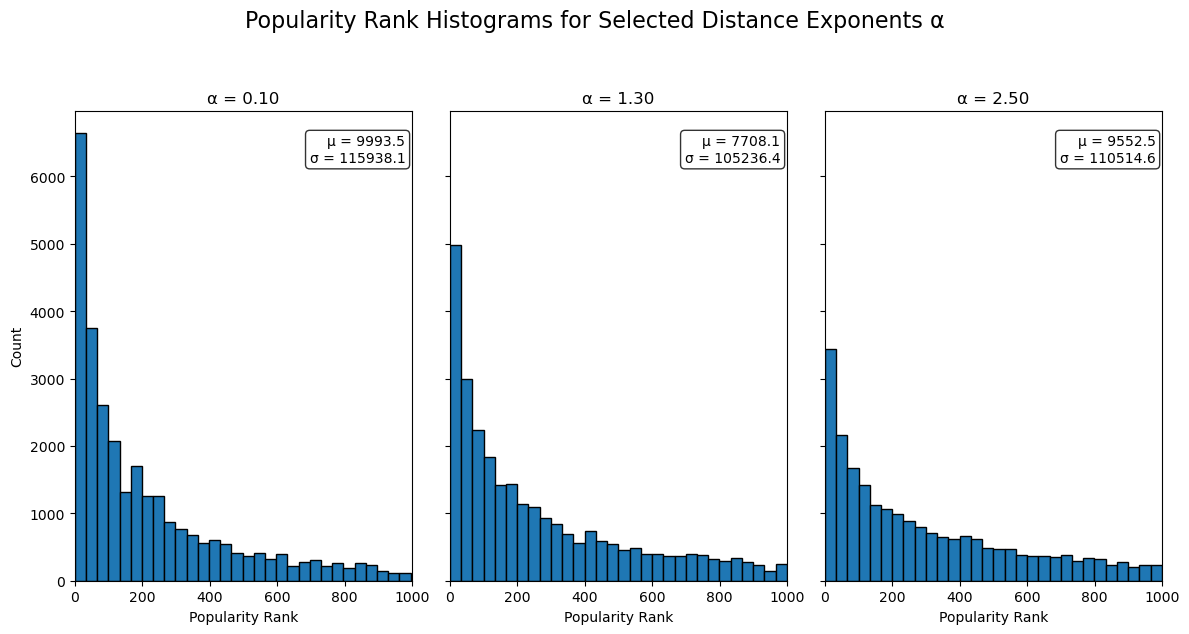

In [6]:
# Select which alpha values (by index) to display
selected = [0, 12, 24]  # change this list as needed

ncols = len(selected)
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 6), sharey=True)
fig.suptitle("Popularity Rank Histograms for Selected Distance Exponents α", fontsize=16, y=1.05)

# Ensure axes is iterable even if ncols = 1
if ncols == 1:
    axes = [axes]

for ax, i in zip(axes, selected):
    dist = popularity_distributions[i]
    hist = []
    for key, val in dist.items():
        hist.extend([key] * val)

    hist = np.array(hist)
    mean_val = hist.mean()
    var_sd = np.sqrt(hist.var())

    ax.hist(hist[hist < 1000], bins=30, edgecolor='black')
    ax.set_title(f"α = {alpha[i]:.2f}", fontsize=12)
    ax.set_xlabel("Popularity Rank", fontsize=10)
    if i == selected[0]:
        ax.set_ylabel("Count", fontsize=10)
    ax.set_xlim(0, 1000)

    stats_text = f"μ = {mean_val:.1f}\nσ = {var_sd:.1f}"
    ax.text(0.98, 0.95, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Popularity Bias Across Distance Function Variants

The following histograms visualize the **popularity ranks** of songs selected by the model under different values of the exponent $\alpha$ in the distance function:

$$f(x) = \frac{1}{x^\alpha + 0.5}$$

Each subplot corresponds to a specific value of $\alpha$ used to compute song-to-song similarity. The **x-axis** represents a song's popularity rank (with lower values indicating more popular songs), and the **y-axis** shows how frequently songs of that rank were selected across all predicted playlists.

These plots allow us to observe how changing $\alpha$ influences the model's tendency to favor popular or less popular tracks.


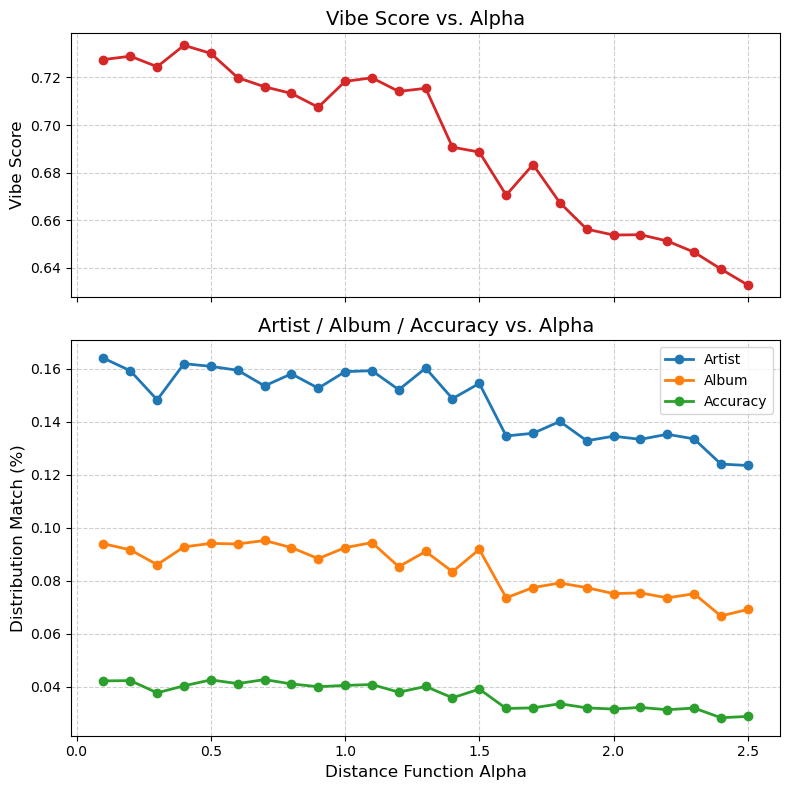

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})

X = alpha

# --- Top plot: Vibe Score ---
ax1.plot(X, vibe_scores, marker='o', linestyle='-', linewidth=2, color='tab:red')
ax1.set_ylabel("Vibe Score", fontsize=12)
ax1.set_title("Vibe Score vs. Alpha", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Bottom plot: Artist, Album, Accuracy ---
ax2.plot(X, artist_scores, marker='o', linestyle='-', linewidth=2, label="Artist")
ax2.plot(X, album_scores, marker='o', linestyle='-', linewidth=2, label="Album")
ax2.plot(X, accuracy_scores, marker='o', linestyle='-', linewidth=2, label="Accuracy")

ax2.set_xlabel("Distance Function Alpha", fontsize=12)
ax2.set_ylabel("Distribution Match (%)", fontsize=12)
ax2.set_title("Artist / Album / Accuracy vs. Alpha", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()


# Spectral Model

### Data Loading

Load data and control its size since the volume of data is enormous for some machines.  
We use only a small fraction of the playlist-track matrix for this experiment:

In [ ]:
P = data.get_playlist_track_matrix()

#control amount of data for slower machines
P,_ = train_test_split(P,train_size= 0.2)


In [8]:
kf = KFold(n_splits=20, shuffle=True, random_state=284)

artist_matrix = data.get_artist_track_matrix()
album_matrix = data.get_album_track_matrix()

# Storage for metrics
dims = []
accuracy_scores = []
artist_scores = []
album_scores = []
vibe_scores = []
popularity_distributions = []

for iter_num, (train_index, test_index) in enumerate(kf.split(P)):
    dim = 50 * (iter_num + 1)
    print(f"Dim: {dim}")

    # Split data
    train_data = P[train_index]
    test_data = P[test_index]

    # Fit model
    model = models.Spotify_Spectral_KNN()
    t_start = time.time()
    model.fit(train_data, dim)
    print("fit time:", time.time() - t_start)

    # Prepare test split
    t_start = time.time()
    test_partial, test_hidden = tools.csr_col_split(test_data, 10, 'shuffle')
    predictions = model.predict(test_partial, k=25)
    print("predict time:", time.time() - t_start)

    # Compute scores
    dims.append(dim)
    accuracy_scores.append(metrics.prediction_accuracy_score(test_hidden, predictions).mean())
    artist_scores.append(metrics.transform_cosine_score(test_hidden, predictions, artist_matrix).mean())
    album_scores.append(metrics.transform_cosine_score(test_hidden, predictions, album_matrix).mean())
    
    cooccur_matrix = train_data.T @ train_data
    vibe_scores.append(metrics.transform_cosine_score(test_hidden, predictions, cooccur_matrix).mean())
    
    popularity_distributions.append(metrics.popularity_bias(predictions, train_data))

    if iter_num >= 10:
        break
    

Dim: 50
fit time: 2.4761710166931152
predict time: 30.70950198173523
Dim: 100
fit time: 5.3474578857421875
predict time: 42.79366493225098
Dim: 150
fit time: 7.895730018615723
predict time: 59.71768593788147
Dim: 200
fit time: 11.502373933792114
predict time: 67.01379489898682
Dim: 250
fit time: 14.683789014816284
predict time: 76.43947315216064
Dim: 300
fit time: 18.839476823806763
predict time: 99.95623207092285
Dim: 350
fit time: 22.998915195465088
predict time: 111.84349226951599
Dim: 400
fit time: 28.3233060836792
predict time: 111.17420411109924
Dim: 450
fit time: 33.73253798484802
predict time: 124.3896381855011
Dim: 500
fit time: 39.06387209892273
predict time: 124.50192093849182
Dim: 550
fit time: 42.51913285255432
predict time: 150.33510303497314


## plot popularity rank historgram

### Popularity Bias Across Latent Dimensions in SVD Model

The histograms below show the **popularity ranks** of songs recommended by the model when using different values of the latent dimension in an SVD-based embedding.

Each subplot corresponds to a particular latent dimensionality used to represent songs and playlists in the model's projection space.

- The **x-axis** represents the popularity rank of each predicted song (lower ranks are more popular).
- The **y-axis** shows the number of times songs at that rank were selected across all test playlists.
- Each plot includes the mean ($\mu$) and standard deviation ($\sigma$) of the rank distribution.

This visualization helps assess how the choice of embedding dimension influences the model's tendency to recommend more or less popular tracks.


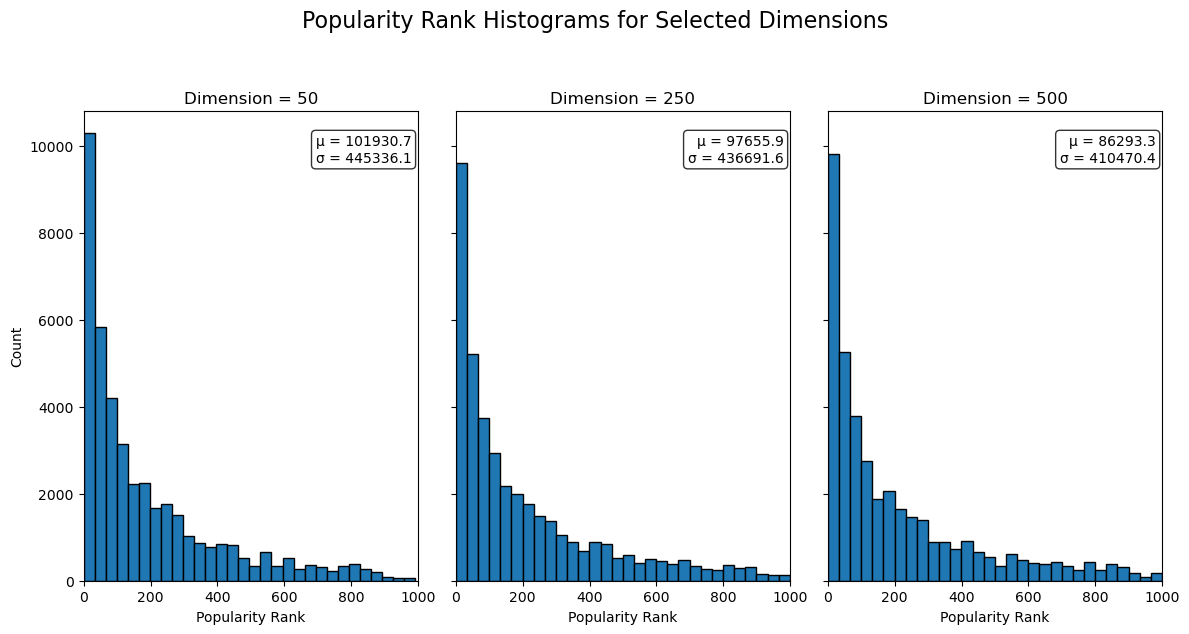

In [9]:
# Select which alpha values (by index) to display
selected = [0, 4, 9]  # change this list as needed

ncols = len(selected)
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 6), sharey=True)
fig.suptitle("Popularity Rank Histograms for Selected Dimensions", fontsize=16, y=1.05)

for ax, i in zip(axes, selected):
    dist = popularity_distributions[i]
    hist = []
    for key, val in dist.items():
        hist.extend([key] * val)

    hist = np.array(hist)
    mean_val = hist.mean()
    var_sd = np.sqrt(hist.var())

    ax.hist(hist[hist < 1000], bins=30, edgecolor='black')
    ax.set_title(f"Dimension = {dims[i]}", fontsize=12)
    ax.set_xlabel("Popularity Rank", fontsize=10)
    if i == selected[0]:
        ax.set_ylabel("Count", fontsize=10)
    ax.set_xlim(0, 1000)

    stats_text = f"μ = {mean_val:.1f}\nσ = {var_sd:.1f}"
    ax.text(0.98, 0.95, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Evaluation Metrics Across Latent Dimensions

The plots below summarize the model’s performance as a function of the number of latent dimensions used in the SVD projection.

- The **top plot** shows the overall **vibe score**, which measures the similarity between predicted and hidden songs in a co-occurrence-based embedding space.
- The **bottom plot** displays the **artist distribution match**, **album distribution match**, and **accuracy** metrics, which assess how well the model preserves artist/album-level structure and exact matches.

These metrics help assess how the dimensionality of the latent space influences recommendation quality across different aspects.


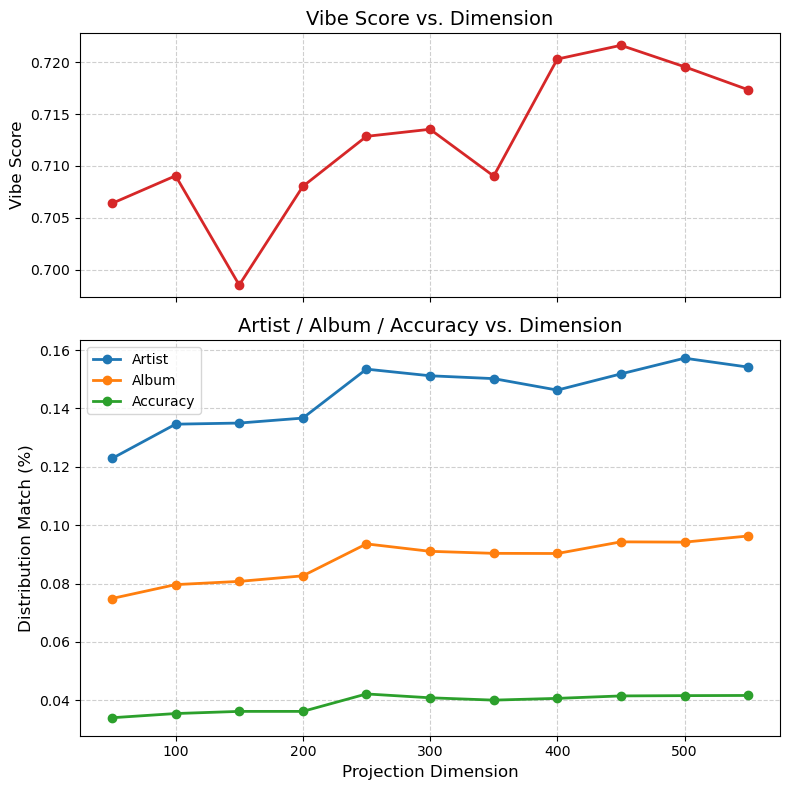

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})

X = dims

# --- Top plot: Vibe Score ---
ax1.plot(X, vibe_scores, marker='o', linestyle='-', linewidth=2, color='tab:red')
ax1.set_ylabel("Vibe Score", fontsize=12)
ax1.set_title("Vibe Score vs. Dimension", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Bottom plot: Artist, Album, Accuracy ---
ax2.plot(X, artist_scores, marker='o', linestyle='-', linewidth=2, label="Artist")
ax2.plot(X, album_scores, marker='o', linestyle='-', linewidth=2, label="Album")
ax2.plot(X, accuracy_scores, marker='o', linestyle='-', linewidth=2, label="Accuracy")

ax2.set_xlabel("Projection Dimension", fontsize=12)
ax2.set_ylabel("Distribution Match (%)", fontsize=12)
ax2.set_title("Artist / Album / Accuracy vs. Dimension", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()


# Explicit Playlist Predictions

In [23]:
P = data.get_playlist_track_matrix()

### Explore playlists

In these section, you can explore playlists as you are used to them: in a human-legible text. Run each cell below to see a specific playlist in the full dataset as well as the track predictions. Adjust the 'playlist_idx' variable to change which playlist you work with.

In [24]:
playlist_idx = 12
m = P[playlist_idx]
data.PrettyPrintPlaylists(m)


=== Playlist 0 (length: 49) ===
  • Track: Limestone
    Artist: Magic City Hippies
    Album: Hippie Castle EP
  • Track: Ease My Mind - Feat. Tre Hardson, Fat Lip & Omni
    Artist: Jazz Liberatorz
    Album: Clin D'oeil
  • Track: North Africa
    Artist: Chick Corea
    Album: The Ultimate Adventure
  • Track: Someone To Love
    Artist: Stephen Marley
    Album: Mind Control Acoustic
  • Track: Tomorrow Maker
    Artist: Mocky
    Album: Key Change
  • Track: Holiday
    Artist: Roy Ayers
    Album: Virgin Ubiquity II
  • Track: Let's Straighten It Out
    Artist: O.V. Wright
    Album: The Bottom Line
  • Track: Sundown Syndrome
    Artist: Tame Impala
    Album: InnerSpeaker
  • Track: A Tune for Jack
    Artist: Lemon Jelly
    Album: Lemon Jelly.ky
  • Track: Blinded By The Light
    Artist: Bruce Springsteen
    Album: Greetings from Asbury Park, N.J.
  • Track: Baby
    Artist: Misun
    Album: Superstitions
  • Track: Old Songs
    Artist: Betty Wright
    Album: Betty Wri

### KNN prediction

In [25]:
#Modify these parameters
num_predict = 10
train_size = 0.1
alpha = 1

# ----------------------------------
P = data.get_playlist_track_matrix()

#control amount of data for slower machines
train,_ = train_test_split(P, train_size= train_size)
print(train.shape[0])

knn = models.Spotify_KNN()
knn.fit(train, lambda x: 1/(x**alpha + 0.5))

80000


In [26]:
my_playlist = P[playlist_idx]
predict = knn.predict(my_playlist, num_predict)
data.PrettyPrintPlaylists(predict)


=== Playlist 0 (length: 10) ===
  • Track: Flatliner (feat. Dierks Bentley)
    Artist: Cole Swindell
    Album: You Should Be Here
  • Track: I Love This Life
    Artist: LOCASH
    Album: The Fighters
  • Track: Small Town Boy
    Artist: Dustin Lynch
    Album: Current Mood
  • Track: Craving You
    Artist: Thomas Rhett
    Album: Life Changes
  • Track: May We All
    Artist: Florida Georgia Line
    Album: Dig Your Roots
  • Track: Gonna Wanna Tonight
    Artist: Chase Rice
    Album: Ignite the Night
  • Track: Any Ol' Barstool
    Artist: Jason Aldean
    Album: They Don't Know
  • Track: I Know Somebody
    Artist: LOCASH
    Album: The Fighters
  • Track: My Girl
    Artist: Dylan Scott
    Album: Dylan Scott
  • Track: What Ifs
    Artist: Kane Brown
    Album: Kane Brown


### Spectral Prediction

In [27]:
#modify parameters 
num_predict = 10
laten_dims = 250

# ----------------------------------

svd = models.Spotify_Spectral_KNN()
svd.fit(train, laten_dims)


In [ ]:
my_playlist = P[playlist_idx]
predict = svd.predict(my_playlist, num_predict)
data.PrettyPrintPlaylists(predict)


=== Playlist 0 (length: 10) ===
  • Track: No Problem (feat. Lil Wayne & 2 Chainz)
    Artist: Chance The Rapper
    Album: Coloring Book
  • Track: iSpy (feat. Lil Yachty)
    Artist: KYLE
    Album: iSpy (feat. Lil Yachty)
  • Track: Congratulations
    Artist: Post Malone
    Album: Stoney
  • Track: Bad and Boujee (feat. Lil Uzi Vert)
    Artist: Migos
    Album: Culture
  • Track: Tunnel Vision
    Artist: Kodak Black
    Album: Painting Pictures
  • Track: Caroline
    Artist: Aminé
    Album: Good For You
  • Track: DNA.
    Artist: Kendrick Lamar
    Album: DAMN.
  • Track: goosebumps
    Artist: Travis Scott
    Album: Birds In The Trap Sing McKnight
  • Track: XO TOUR Llif3
    Artist: Lil Uzi Vert
    Album: Luv Is Rage 2
  • Track: T-Shirt
    Artist: Migos
    Album: Culture
